In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [2]:
feature_id = 376  # high peptide score in Mascot
DELTA_MZ = 1.003355  # Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.

In [109]:
MASS_DEFECT_WINDOW_DA_MIN = 100  # range in Daltons
MASS_DEFECT_WINDOW_DA_MAX = 5200

In [6]:
raw_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/feature-376-ms2-raw-points.csv')
raw_df['normalised_intensity'] = raw_df.intensity / raw_df.intensity.max()

In [111]:
def generate_mass_defect_windows():
    bin_edges_l = []
    for nominal_mass in range(MASS_DEFECT_WINDOW_DA_MIN, MASS_DEFECT_WINDOW_DA_MAX):
        mass_centre = nominal_mass * 1.00048  # from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3184890/
        width = 0.19 + (0.0001 * nominal_mass)
        lower_mass = mass_centre - (width / 2)
        upper_mass = mass_centre + (width / 2)
        bin_edges_l.append(lower_mass)
        bin_edges_l.append(upper_mass)
    bins = np.asarray(bin_edges_l)
    return bins

In [112]:
mass_defect_window_bins = generate_mass_defect_windows()

In [113]:
mass_defect_window_bins

array([  99.948  ,  100.148  ,  100.94843, ..., 5200.84994, 5201.14057,
       5201.85047])

In [114]:
len(mass_defect_window_bins)

10200

In [120]:
from ms_peak_picker import simple_peak

In [130]:
peaks_l = []
for i in range(len(raw_df)):
    peaks_l.append(simple_peak(raw_df.iloc[i].mz, raw_df.iloc[i].intensity))
peaks_a = np.array(peaks_l)

In [134]:
vectorise_mz = np.vectorize(lambda obj: obj.mz)
vectorise_intensity = np.vectorize(lambda obj: obj.intensity)

In [135]:
def remove_points_outside_mass_defect_windows(ms2_peaks_a, mass_defect_window_bins):
    mz_a = vectorise_mz(ms2_peaks_a)
    inside_mass_defect_window_a = np.full((len(mz_a)), False)
    for charge in [3,2,1]:
        decharged_mass_a = (mz_a * charge) - (PROTON_MASS * charge)
        decharged_mass_bin_indexes = np.digitize(decharged_mass_a, mass_defect_window_bins)  # an odd index means the point is inside a mass defect window
        mass_defect_window_indexes = (decharged_mass_bin_indexes % 2) == 1  # odd bin indexes are mass defect windows
        # not_mass_defect_window_indexes = (decharged_mass_bin_indexes % 2) == 0
        inside_mass_defect_window_a[mass_defect_window_indexes] = True
    result = ms2_peaks_a[inside_mass_defect_window_a]
    return result

In [132]:
peaks_inside_a = remove_points_outside_mass_defect_windows(peaks_a, mass_defect_window_bins)
number_of_points_inside_mass_defect_windows = np.count_nonzero(peaks_inside_a)
total_points = len(peaks_a)
print("{}% of points are not inside a mass defect window".format(round((total_points-number_of_points_inside_mass_defect_windows)/total_points*100,1)))

4.3% of points are not inside a mass defect window


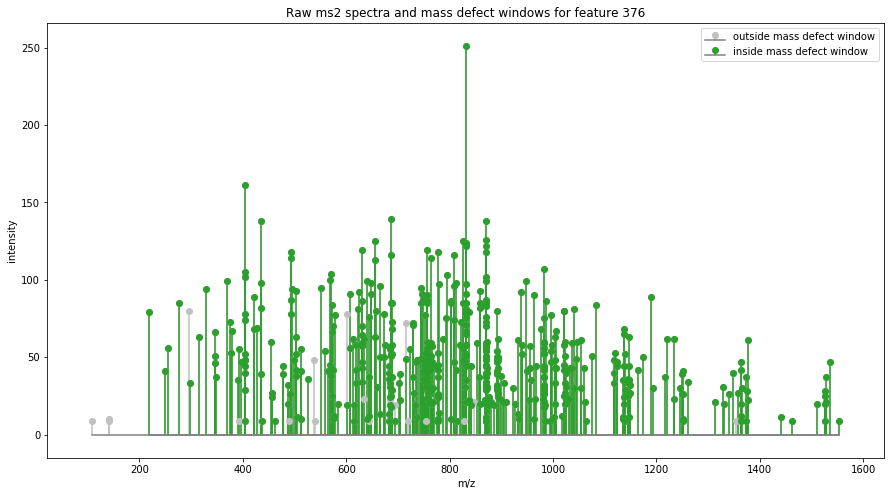

In [137]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

PLOT_DA_MIN = 1000
PLOT_DA_MAX = 400

markerline, stemlines, baseline = ax.stem(vectorise_mz(peaks_a), vectorise_intensity(peaks_a), label='outside mass defect window', use_line_collection=True)
plt.setp(markerline, 'color', 'silver')
plt.setp(stemlines, 'color', 'silver')
plt.setp(baseline, 'color', colors[7])

markerline, stemlines, baseline = ax.stem(vectorise_mz(peaks_inside_a), vectorise_intensity(peaks_inside_a), label='inside mass defect window', use_line_collection=True)
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])

for l in mass_defect_window_bins[(mass_defect_window_bins >= PLOT_DA_MIN) & (mass_defect_window_bins <= PLOT_DA_MAX)]:
    plt.axvline(x=l, linestyle=':', color='gray')

plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(8)
f.set_figwidth(15)
# ax.set_xlim((PLOT_DA_MIN,PLOT_DA_MAX))
plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms2 spectra and mass defect windows for feature {}'.format(feature_id))
plt.show()